In [22]:
# ==========================================================
# BLOCCO 1: Elaborazione file per file di ZeekData22 
# ==========================================================
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import seaborn as sns
import matplotlib.pyplot as plt

# ----------------------------
# Cartelle
# ----------------------------
input_dir = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekData22"
output_dir = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22"
os.makedirs(output_dir, exist_ok=True)

# ----------------------------
# Lista file CSV/Parquet
# ----------------------------
all_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) 
             if f.endswith('.csv') or f.endswith('.parquet')]

# ----------------------------
# Funzione di pulizia e trasformazione
# ----------------------------
def clean_and_transform(df):
    df = df.copy()
    
    # Pulizia valori numerici
    for col in df.select_dtypes(include=['float64','int64']).columns:
        df.loc[:, col] = df[col].fillna(df[col].mean())
    
    # Pulizia valori categorici
    for col in df.select_dtypes(include=['object','category']).columns:
        mode_val = df[col].mode()[0] if not df[col].mode().empty else 'unknown'
        df.loc[:, col] = df[col].fillna(mode_val)
    
    # Pulizia label_binary
    if 'label_binary' in df.columns:
        df['label_binary'] = df['label_binary'].map({True:1, False:0, 'True':1, 'False':0, 1:1, 0:0})
        df = df.dropna(subset=['label_binary'])
        df['label_binary'] = df['label_binary'].astype(int)
    
    # Selezione feature numeriche (escludendo label)
    num_features = df.select_dtypes(include=['int64','float64']).columns.tolist()
    for col in ['label_binary','label_technique','label_tactic']:
        if col in num_features:
            num_features.remove(col)
    
    # Rimuovi feature a bassa varianza
    variance = df[num_features].var()
    selected_features = variance[variance > 0.01].index.tolist()
    
    # Winsorization + log-transform
    for col in selected_features:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower, upper)
        min_val = df[col].min()
        offset = abs(min_val)+1e-6 if min_val <= 0 else 0
        df[col] = np.log1p(df[col] + offset)
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Rimozione eventuali NaN residui
    df = df.dropna(subset=selected_features)
    
    # A questo punto il file è pulito e trasformato, **senza bilanciamento**
    return df

# ----------------------------
# Elaborazione file per file
# ----------------------------
for file_path in tqdm(all_files, desc="Processing ZeekData22"):
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        else:
            df = pd.read_parquet(file_path)
        
        df_clean = clean_and_transform(df)
        
        base_name = os.path.basename(file_path)
        output_file = os.path.join(output_dir, f"processed_{base_name}.parquet")
        df_clean.to_parquet(output_file, index=False)
        
    except Exception as e:
        print(f"⚠️ Errore con file {file_path}: {e}")

print(f"\n✅ Tutti i file elaborati e salvati in: {output_dir}")


Processing ZeekData22: 100%|██████████| 14/14 [02:21<00:00, 10.12s/it]

⚠️ Errore con file C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekData22\part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet: Unable to allocate 637. MiB for an array with shape (9, 9280806) and data type object

✅ Tutti i file elaborati e salvati in: C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22


In [1]:
# ==========================================================
# BLOCCO 2 (memory-safe): Visualizzazione colonne e distribuzione label_tactic
# ==========================================================
import os
import pandas as pd
from tqdm import tqdm
import gc

# Cartella dei file già processati
processed_dir = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22"
processed_files = [os.path.join(processed_dir, f) for f in os.listdir(processed_dir) if f.endswith('.parquet')]

# ----------------------------
# Set per accumulare colonne
# ----------------------------
all_columns = set()
tactic_counts_total = {}

# ----------------------------
# Iterazione file per file (memory-safe)
# ----------------------------
for file_path in tqdm(processed_files, desc="Scan files"):
    df = pd.read_parquet(file_path)
    
    # Accumula nomi colonne
    all_columns.update(df.columns.tolist())
    
    # Conta label_tactic
    if 'label_tactic' in df.columns:
        counts = df['label_tactic'].value_counts()
        for tac, val in counts.items():
            tactic_counts_total[tac] = tactic_counts_total.get(tac, 0) + val
    
    del df
    gc.collect()

# ----------------------------
# 1️⃣ Elenco colonne
# ----------------------------
columns_df = pd.DataFrame({'Colonne disponibili': list(all_columns)})
display(columns_df)

# ----------------------------
# 2️⃣ Distribuzione label_tactic
# ----------------------------
if tactic_counts_total:
    tactic_df = pd.DataFrame({
        'Tattica': list(tactic_counts_total.keys()),
        'Conteggio': list(tactic_counts_total.values())
    })
    tactic_df['Percentuale (%)'] = (tactic_df['Conteggio'] / sum(tactic_df['Conteggio']) * 100).round(2)
    display(tactic_df)
else:
    print("⚠️ Colonna 'label_tactic' non presente in nessun file")


Scan files: 100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


,Colonne disponibili
0,resp_ip_bytes
1,2021-12-19 - 2021-12-26
2,2021-12-12 - 2021-12-19
3,resp_pkts
4,orig_bytes
5,service
6,src_port
7,label_tactic_reduced
8,ts
9,proto


,Tattica,Conteggio,Percentuale (%)
0,Resource Development,262413,1.39
1,Reconnaissance,9329757,49.37
2,Discovery,20199,0.11
3,Defense Evasion,2897,0.02
4,Execution,29,0.00
5,Initial Access,20,0.00
6,Command and Control,14,0.00
7,Lateral Movement,15,0.00
8,Persistence,11,0.00
9,Collection,1,0.00


In [2]:
# ==========================================================
# BLOCCO 3 (memory-safe): Confronto colonne ZeekData22 vs ZeekDataFall22
# ==========================================================
import os
import pandas as pd
from tqdm import tqdm
import random

# === Percorsi ===
processed_dir_22 = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\filtered_chunks"
folder_fall22 = r"C:\Users\maria\Desktop\Zeek_ML\UWF-ZeekDataFall22"

# === 1️⃣ ZeekData22: raccolta colonne e campione casuale ===
all_files_22 = [os.path.join(processed_dir_22, f) for f in os.listdir(processed_dir_22) if f.endswith('.parquet')]
cols_22 = set()
sample_rows_22 = []

for file_path in tqdm(all_files_22, desc="Scansione ZeekData22"):
    df = pd.read_parquet(file_path)
    cols_22.update(df.columns.tolist())
    
    # Prendi un campione casuale di righe per confronto
    sample_size = min(1000, len(df))
    sample_rows_22.append(df.sample(n=sample_size, random_state=42))
    
    del df

sample_22 = pd.concat(sample_rows_22, ignore_index=True)
del sample_rows_22

# === 2️⃣ ZeekDataFall22: colonne e campione ===
all_files_fall22 = [os.path.join(folder_fall22, f) for f in os.listdir(folder_fall22) if f.endswith('.csv') or f.endswith('.parquet')]
cols_fall22 = set()
sample_rows_fall22 = []

for f in tqdm(all_files_fall22, desc="Scansione ZeekDataFall22"):
    if f.endswith('.csv'):
        df = pd.read_csv(f)
    else:
        df = pd.read_parquet(f)
    
    cols_fall22.update(df.columns.tolist())
    
    sample_size = min(1000, len(df))
    sample_rows_fall22.append(df.sample(n=sample_size, random_state=42))
    
    del df

sample_fall22 = pd.concat(sample_rows_fall22, ignore_index=True)
del sample_rows_fall22

# === 3️⃣ Confronto diretto nomi colonne ===
common_cols = sorted(list(cols_22.intersection(cols_fall22)))
only_in_22 = sorted(list(cols_22 - cols_fall22))
only_in_fall22 = sorted(list(cols_fall22 - cols_22))

print("✅ Colonne comuni:", len(common_cols))
print("❌ Solo in ZeekData22:", len(only_in_22))
print("❌ Solo in ZeekDataFall22:", len(only_in_fall22))

diff_table = pd.DataFrame({
    "Solo in ZeekData22": pd.Series(only_in_22),
    "Solo in ZeekDataFall22": pd.Series(only_in_fall22)
})
display(diff_table)

# === 4️⃣ Analisi somiglianza colonne con nome diverso ===
similarity_report = []

for col_22 in only_in_22:
    for col_fall in only_in_fall22:
        try:
            # entrambe numeriche
            if pd.api.types.is_numeric_dtype(sample_22[col_22]) and pd.api.types.is_numeric_dtype(sample_fall22[col_fall]):
                corr = sample_22[col_22].corr(sample_fall22[col_fall])
                if corr > 0.95:
                    similarity_report.append((col_22, col_fall, f"Numerica - Corr: {corr:.3f}"))
            # entrambe categoriche
            elif pd.api.types.is_object_dtype(sample_22[col_22]) and pd.api.types.is_object_dtype(sample_fall22[col_fall]):
                overlap = (sample_22[col_22].isin(sample_fall22[col_fall])).mean()
                if overlap > 0.9:
                    similarity_report.append((col_22, col_fall, f"Categorica - Overlap: {overlap:.2%}"))
        except Exception:
            continue

if similarity_report:
    print("\n🔍 Colonne con contenuto simile ma nome diverso:")
    sim_df = pd.DataFrame(similarity_report, columns=["Colonna ZeekData22", "Colonna ZeekDataFall22", "Somiglianza"])
    display(sim_df)
else:
    print("\nℹ️ Nessuna colonna con contenuto simile trovata tra i nomi diversi.")


Scansione ZeekDataFall22: 100%|██████████| 16/16 [00:00<00:00, 21.63it/s]

✅ Colonne comuni: 28
❌ Solo in ZeekData22: 11
❌ Solo in ZeekDataFall22: 10


,Solo in ZeekData22,Solo in ZeekDataFall22
0,2022-01-09 - 2022-01-16,2022-08-28 - 2022-09-04
1,2022-01-16 - 2022-01-23,2022-09-04 - 2022-09-11
2,2022-02-06 - 2022-02-13,2022-09-11 - 2022-09-18
3,2022-02-13 - 2022-02-20,2022-09-18 - 2022-09-25
4,dest_ip,2022-09-25 - 2022-10-02
5,dest_port,2022-10-02 - 2022-10-09
6,label_tactic_reduced,2022-10-09 - 2022-10-16
7,mitre_attack_tactics,2022-10-16 - 2022-10-23
8,protocol,2022-10-23 - 2022-10-30
9,src_ip,label_binary



🔍 Colonne con contenuto simile ma nome diverso:


,Colonna ZeekData22,Colonna ZeekDataFall22,Somiglianza
0,2022-01-09 - 2022-01-16,2022-08-28 - 2022-09-04,Categorica - Overlap: 99.85%
1,2022-01-09 - 2022-01-16,2022-09-04 - 2022-09-11,Categorica - Overlap: 99.85%
2,2022-01-09 - 2022-01-16,2022-09-11 - 2022-09-18,Categorica - Overlap: 99.85%
3,2022-01-09 - 2022-01-16,2022-09-18 - 2022-09-25,Categorica - Overlap: 99.85%
4,2022-01-09 - 2022-01-16,2022-09-25 - 2022-10-02,Categorica - Overlap: 99.85%
5,2022-01-09 - 2022-01-16,2022-10-02 - 2022-10-09,Categorica - Overlap: 99.85%
6,2022-01-09 - 2022-01-16,2022-10-09 - 2022-10-16,Categorica - Overlap: 99.85%
7,2022-01-09 - 2022-01-16,2022-10-16 - 2022-10-23,Categorica - Overlap: 99.85%
8,2022-01-09 - 2022-01-16,2022-10-23 - 2022-10-30,Categorica - Overlap: 99.85%
9,2022-01-09 - 2022-01-16,label_binary,Categorica - Overlap: 99.85%


In [6]:
# ==========================================================
# BLOCCO 4: Estrazione e salvataggio feature categoriali (robusto e memory-safe)
# ==========================================================
import os
import pandas as pd
from tqdm import tqdm

# === Percorsi ===
processed_dir_22 = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\filtered_chunks"
output_path = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\categorical_features.parquet"

# === Lista colonne categoriali da inferire o predefinire ===
first_file = [os.path.join(processed_dir_22, f) for f in os.listdir(processed_dir_22) if f.endswith('.parquet')][0]
sample_df = pd.read_parquet(first_file)
cat_features = sample_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"📋 Feature categoriali individuate: {cat_features}")

# === Estrazione incrementale e robusta ===
cat_dfs = []
for file_name in tqdm(os.listdir(processed_dir_22), desc="Estrazione colonne categoriali"):
    if not file_name.endswith('.parquet'):
        continue

    file_path = os.path.join(processed_dir_22, file_name)
    df = pd.read_parquet(file_path)

    # Prendi solo le colonne categoriali presenti
    available_cols = [c for c in cat_features if c in df.columns]

    # Crea DataFrame solo con le colonne disponibili
    temp_df = df[available_cols].copy()

    # Aggiungi colonne mancanti come NaN per mantenere lo schema uniforme
    for missing_col in set(cat_features) - set(available_cols):
        temp_df[missing_col] = pd.NA

    cat_dfs.append(temp_df)
    del df, temp_df

# === Unione e salvataggio finale ===
cat_features_df = pd.concat(cat_dfs, ignore_index=True)
del cat_dfs

cat_features_df.to_parquet(output_path, index=False)
print(f"💾 Feature categoriali salvate in '{output_path}' "
      f"({cat_features_df.shape[1]} colonne, {cat_features_df.shape[0]} righe)")


📋 Feature categoriali individuate: ['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic', 'label_technique', 'label_tactic_reduced']


Estrazione colonne categoriali: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


💾 Feature categoriali salvate in 'C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\categorical_features.parquet' (11 colonne, 32266581 righe)


Filtering ZeekData22: 100%|██████████| 18/18 [01:52<00:00,  6.27s/it]



📊 Totale righe iniziali: 73484405
⚠️ Benigni rimossi: 9281600 (12.63%)
✅ Righe rimanenti: 64202805


Analisi varianza ZeekData22: 100%|██████████| 18/18 [00:33<00:00,  1.88s/it]


📊 Feature numeriche trovate: 13


,Feature,Varianza,Significativa (>0.01)
0,src_port_zeek,5.702579,✅
1,dest_port_zeek,3.885512,✅
2,resp_ip_bytes,3.311140,✅
3,orig_bytes,2.259162,✅
4,orig_ip_bytes,1.816889,✅
5,resp_bytes,1.742718,✅
6,duration,0.929437,✅
7,dest_port,0.784002,✅
8,src_port,0.689480,✅
9,resp_pkts,0.230330,✅



✅ Feature con varianza significativa (11): ['src_port_zeek', 'dest_port_zeek', 'resp_ip_bytes', 'orig_bytes', 'orig_ip_bytes', 'resp_bytes', 'duration', 'dest_port', 'src_port', 'resp_pkts']...
💾 Salvato in: C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\feature_variance_zeekdata22.csv


Trasformazione chunk: 100%|██████████| 18/18 [00:55<00:00,  3.08s/it]


✅ Tutti i chunk trasformati salvati in: C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\transformed_chunks

📊 Confronto varianza ZeekData22 vs ZeekDataFall22:


,Feature,Varianza_ZeekData22,Significativa (>0.01)_ZeekData22,Varianza_ZeekDataFall22,Significativa (>0.01)_ZeekDataFall22
0,src_port_zeek,5.702579,✅,1.452377e-02,✅
1,dest_port_zeek,3.885512,✅,5.268928e+00,✅
2,resp_ip_bytes,3.311140,✅,3.961552e+00,✅
3,orig_bytes,2.259162,✅,4.614113e-02,✅
4,orig_ip_bytes,1.816889,✅,3.625395e-01,✅
5,resp_bytes,1.742718,✅,1.185336e-01,✅
6,duration,0.929437,✅,3.590875e-02,✅
7,dest_port,0.784002,✅,0.000000e+00,0
8,src_port,0.689480,✅,0.000000e+00,0
9,resp_pkts,0.230330,✅,2.918403e-01,✅


c:\Users\maria\anaconda3\envs\zeek-ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


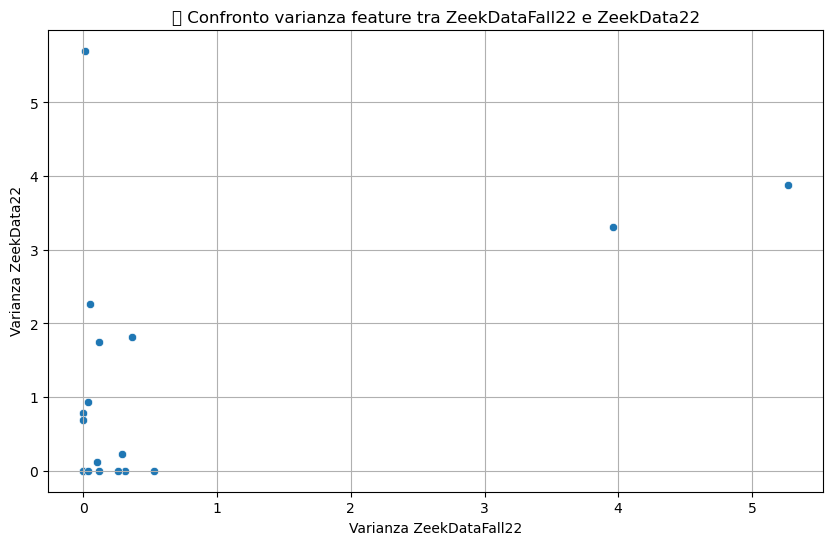

Statistiche descrittive chunk: 100%|██████████| 18/18 [00:43<00:00,  2.42s/it]


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# ==========================================================
# BLOCCO 4: Analisi ZeekData22 (pulizia, varianza e confronto con ZeekDataFall22) - VERSIONE MEMORY SAFE
# ==========================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc

# ------------------------------
# Step 1️⃣ - Setup
# ------------------------------
processed_dir = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22"
temp_dir = os.path.join(processed_dir, "filtered_chunks")
os.makedirs(temp_dir, exist_ok=True)

processed_files = [os.path.join(processed_dir, f)
                   for f in os.listdir(processed_dir)
                   if f.endswith('.parquet')]

total_rows, benign_rows, kept_rows = 0, 0, 0

# ------------------------------
# Step 2️⃣ - Filtraggio chunk per chunk
# ------------------------------
for i, file in enumerate(tqdm(processed_files, desc="Filtering ZeekData22")):
    df = pd.read_parquet(file)
    total_rows += len(df)

    if 'label_tactic' in df.columns:
        benign_count = (df['label_tactic'] == 'none').sum()
        benign_rows += benign_count
        df = df[df['label_tactic'] != 'none']

    kept_rows += len(df)
    chunk_path = os.path.join(temp_dir, f"filtered_chunk_{i}.parquet")
    df.to_parquet(chunk_path, index=False)
    del df
    gc.collect()

print(f"\n📊 Totale righe iniziali: {total_rows}")
print(f"⚠️ Benigni rimossi: {benign_rows} ({benign_rows/total_rows*100:.2f}%)")
print(f"✅ Righe rimanenti: {kept_rows}")

# ------------------------------
# Step 3️⃣ - Analisi incrementale delle feature numeriche
# ------------------------------
variance_sum = {}
variance_count = {}
cat_features = set()

for file_path in tqdm(os.listdir(temp_dir), desc="Analisi varianza ZeekData22"):
    df = pd.read_parquet(os.path.join(temp_dir, file_path))

    num_cols = df.select_dtypes(include=['int64','float64']).columns
    cat_cols = df.select_dtypes(include=['object','category']).columns
    cat_features.update(cat_cols)

    # Calcolo varianza incrementale
    for col in num_cols:
        var_chunk = df[col].var()
        if not np.isnan(var_chunk):
            variance_sum[col] = variance_sum.get(col, 0) + var_chunk
            variance_count[col] = variance_count.get(col, 0) + 1

    del df
    gc.collect()

# Media della varianza sui chunk
variance = {col: variance_sum[col] / variance_count[col] for col in variance_sum}
variance_series = pd.Series(variance).sort_values(ascending=False)

# ------------------------------
# Step 4️⃣ - Tabella varianza e salvataggio
# ------------------------------
var_table = pd.DataFrame({
    'Feature': variance_series.index,
    'Varianza': variance_series.values,
    'Significativa (>0.01)': ['✅' if v > 0.01 else '❌' for v in variance_series.values]
})

print(f"\n📊 Feature numeriche trovate: {len(var_table)}")
display(var_table.head(10))

selected_features = var_table.loc[var_table['Varianza'] > 0.01, 'Feature'].tolist()
print(f"\n✅ Feature con varianza significativa ({len(selected_features)}): {selected_features[:10]}...")

variance22_path = os.path.join(processed_dir, "feature_variance_zeekdata22.csv")
var_table.to_csv(variance22_path, index=False)
print(f"💾 Salvato in: {variance22_path}")

# ------------------------------
# Step 5️⃣ - Trasformazioni chunk-based (Winsorization + Log) - versione robusta
# ------------------------------
transformed_dir = os.path.join(processed_dir, "transformed_chunks")
os.makedirs(transformed_dir, exist_ok=True)

for file_name in tqdm(os.listdir(temp_dir), desc="Trasformazione chunk"):
    if not file_name.endswith(".parquet"):
        continue

    file_path = os.path.join(temp_dir, file_name)
    df = pd.read_parquet(file_path)

    # 🔹 Interseca solo le feature effettivamente presenti nel chunk
    available_cols = [c for c in selected_features if c in df.columns]
    missing_cols = set(selected_features) - set(available_cols)

    # 🔹 Aggiungi colonne mancanti come NaN
    for mc in missing_cols:
        df[mc] = np.nan

    # 🔹 Trasformazioni solo sulle colonne presenti
    for col in available_cols:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = np.clip(df[col], lower, upper)
        offset = abs(df[col].min()) + 1e-6 if df[col].min() <= 0 else 0
        df[col] = np.log1p(df[col] + offset)
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        df[col].fillna(0, inplace=True)

    # 🔹 Salva solo le colonne selezionate (tutte presenti o create)
    transformed_path = os.path.join(transformed_dir, f"transformed_{file_name}")
    df[selected_features].to_parquet(transformed_path, index=False)

    del df
    gc.collect()

print(f"\n✅ Tutti i chunk trasformati salvati in: {transformed_dir}")


# ------------------------------
# Step 6️⃣ - Confronto varianza con ZeekDataFall22
# ------------------------------
fall22_var_path = os.path.join(processed_dir, "feature_variance_fall22.csv")
if os.path.exists(fall22_var_path):
    var_fall22 = pd.read_csv(fall22_var_path)
    merged_var = pd.merge(var_table, var_fall22, on='Feature', how='outer', suffixes=('_ZeekData22', '_ZeekDataFall22'))
    merged_var.fillna(0, inplace=True)

    print("\n📊 Confronto varianza ZeekData22 vs ZeekDataFall22:")
    display(merged_var.head(20))

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=merged_var, x='Varianza_ZeekDataFall22', y='Varianza_ZeekData22')
    plt.title("📈 Confronto varianza feature tra ZeekDataFall22 e ZeekData22")
    plt.xlabel("Varianza ZeekDataFall22")
    plt.ylabel("Varianza ZeekData22")
    plt.grid(True)
    plt.show()
else:
    print("\n⚠️ File feature_variance_fall22.csv non trovato, confronto non eseguito.")

# ------------------------------
# Step 7️⃣ - Esportazione statistiche descrittive globali (memory-safe e robusta)
# ------------------------------
desc_table = []

for file_path in tqdm(os.listdir(transformed_dir), desc="Statistiche descrittive chunk"):
    if not file_path.endswith(".parquet"):
        continue
    df = pd.read_parquet(os.path.join(transformed_dir, file_path))
    
    # Calcolo statistiche descrittive solo numeriche
    desc = df.describe().T
    desc["chunk"] = file_path
    desc_table.append(desc)
    
    del df
    gc.collect()

# Concatenazione incrementale
desc_all = pd.concat(desc_table)
del desc_table
gc.collect()

# Calcolo media solo su colonne numeriche
numeric_cols = desc_all.select_dtypes(include=[np.number]).columns
desc_mean = desc_all.groupby(desc_all.index)[numeric_cols].mean(numeric_only=True)

print("\n📄 Statistiche descrittive (post trasformazione):")
display(desc_mean.head(15))

# 💾 Salvataggio opzionale
desc_mean_path = os.path.join(processed_dir, "global_descriptive_stats_zeekdata22.csv")
desc_mean.to_csv(desc_mean_path)
print(f"💾 Statistiche descrittive globali salvate in: {desc_mean_path}")



📦 Trovati 18 chunk da analizzare.


Analisi progressiva ZeekData22:   0%|          | 0/18 [00:00<?, ?it/s]


🔹 Colonne numeriche (0): []...
🔹 Colonne categoriali (11): ['community_id', 'conn_state', 'history', 'src_ip_zeek', 'dest_ip_zeek', 'proto', 'service', 'uid', 'label_tactic', 'label_technique']...



Analisi progressiva ZeekData22: 100%|██████████| 18/18 [00:41<00:00,  2.30s/it]


✅ Analisi completata su 64,202,805 righe totali.

📊 Tabella varianza (campione ZeekData22):


,Feature,Varianza,Significativa (>0.01)


💾 Tabella varianza ZeekData22 salvata in: C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\feature_variance_zeekdata22.csv

⚠️ Colonne con valori nulli:


,Colonna,Valori_Nulli,Percentuale
9,label_technique,31936224,49.743
10,label_tactic_reduced,22655410,35.287
3,src_ip_zeek,22655355,35.287
4,dest_ip_zeek,22655355,35.287
5,proto,22655355,35.287
8,label_tactic,22651166,35.281
0,community_id,20610621,32.102
1,conn_state,20610621,32.102
2,history,20610621,32.102
6,service,20610621,32.102



📈 Confronto varianza ZeekData22 vs ZeekDataFall22:


,Varianza_ZeekData22,Significativa (>0.01)_ZeekData22,Feature,Varianza_ZeekDataFall22,Significativa (>0.01)_ZeekDataFall22
0,0,0.0,dest_port_zeek,5.268928e+00,✅
1,0,0.0,resp_ip_bytes,3.961552e+00,✅
2,0,0.0,total_resp_pkts,5.298928e-01,✅
3,0,0.0,orig_ip_bytes,3.625395e-01,✅
4,0,0.0,total_resp_bytes,3.125160e-01,✅
5,0,0.0,resp_pkts,2.918403e-01,✅
6,0,0.0,total_orig_pkts,2.570628e-01,✅
7,0,0.0,resp_bytes,1.185336e-01,✅
8,0,0.0,total_orig_bytes,1.138155e-01,✅
9,0,0.0,orig_pkts,1.043374e-01,✅


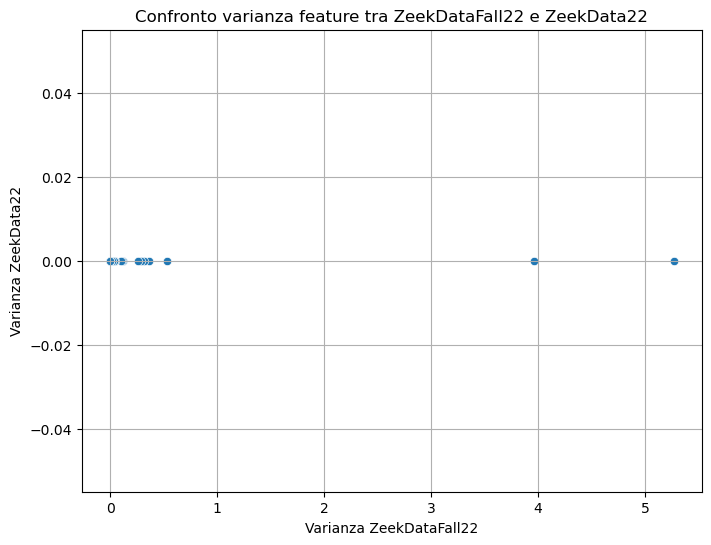

In [8]:
# ==========================================================
# BLOCCO 4 (versione memory-safe)
# Analisi ZeekData22 (pulizia, varianza e confronto con ZeekDataFall22)
# ==========================================================
import os
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

processed_dir = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22"
temp_dir = os.path.join(processed_dir, "filtered_chunks")

processed_chunks = [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.endswith('.parquet')]
print(f"📦 Trovati {len(processed_chunks)} chunk da analizzare.")

# ================================
# Step 1️⃣ - Analisi progressiva
# ================================
num_cols, cat_cols = None, None
var_accumulator = {}
count_accumulator = {}
null_counts = {}
total_rows = 0

for file in tqdm(processed_chunks, desc="Analisi progressiva ZeekData22"):
    df = pd.read_parquet(file)
    total_rows += len(df)

    # rileva colonne numeriche e categoriali solo una volta
    if num_cols is None:
        num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        print(f"\n🔹 Colonne numeriche ({len(num_cols)}): {num_cols[:10]}...")
        print(f"🔹 Colonne categoriali ({len(cat_cols)}): {cat_cols[:10]}...\n")

    # aggiorna conteggi nulli
    null_counts_chunk = df.isna().sum().to_dict()
    for k, v in null_counts_chunk.items():
        null_counts[k] = null_counts.get(k, 0) + v

    # aggiorna somma e somma dei quadrati per varianza
    for col in num_cols:
        series = df[col].dropna().astype(float)
        if col not in var_accumulator:
            var_accumulator[col] = {'sum': 0, 'sum_sq': 0, 'count': 0}
        var_accumulator[col]['sum'] += series.sum()
        var_accumulator[col]['sum_sq'] += np.square(series).sum()
        var_accumulator[col]['count'] += len(series)

    del df
    gc.collect()

print(f"\n✅ Analisi completata su {total_rows:,} righe totali.")

# ================================
# Step 2️⃣ - Calcolo varianza aggregata
# ================================
variance_data = []
for col, stats in var_accumulator.items():
    n = stats['count']
    if n > 1:
        mean = stats['sum'] / n
        var = (stats['sum_sq'] / n) - (mean ** 2)
    else:
        var = np.nan
    variance_data.append((col, var))

var_table = pd.DataFrame(variance_data, columns=['Feature', 'Varianza'])
var_table['Significativa (>0.01)'] = ['✅' if v > 0.01 else '❌' for v in var_table['Varianza']]

print("\n📊 Tabella varianza (campione ZeekData22):")
display(var_table.sort_values('Varianza', ascending=False).head(20))

variance22_path = os.path.join(processed_dir, "feature_variance_zeekdata22.csv")
var_table.to_csv(variance22_path, index=False)
print(f"💾 Tabella varianza ZeekData22 salvata in: {variance22_path}")

# ================================
# Step 3️⃣ - Colonne con valori nulli
# ================================
null_df = pd.DataFrame(list(null_counts.items()), columns=['Colonna', 'Valori_Nulli'])
null_df['Percentuale'] = (null_df['Valori_Nulli'] / total_rows * 100).round(3)
null_df = null_df[null_df['Valori_Nulli'] > 0].sort_values('Valori_Nulli', ascending=False)

if len(null_df) > 0:
    print("\n⚠️ Colonne con valori nulli:")
    display(null_df.head(15))
else:
    print("\n✅ Nessun valore nullo trovato nei chunk analizzati.")

# ================================
# Step 4️⃣ - Confronto con ZeekDataFall22
# ================================
fall22_var_path = os.path.join(processed_dir, "feature_variance_fall22.csv")
if os.path.exists(fall22_var_path):
    var_fall22 = pd.read_csv(fall22_var_path)
    var22 = var_table.copy()

    merged_var = pd.merge(var22, var_fall22, on='Feature', how='outer', suffixes=('_ZeekData22','_ZeekDataFall22'))
    merged_var.fillna(0, inplace=True)

    print("\n📈 Confronto varianza ZeekData22 vs ZeekDataFall22:")
    display(merged_var.head(20))

    plt.figure(figsize=(8,6))
    sns.scatterplot(data=merged_var, x='Varianza_ZeekDataFall22', y='Varianza_ZeekData22')
    plt.title("Confronto varianza feature tra ZeekDataFall22 e ZeekData22")
    plt.xlabel("Varianza ZeekDataFall22")
    plt.ylabel("Varianza ZeekData22")
    plt.grid(True)
    plt.show()
else:
    print("\n⚠️ File feature_variance_fall22.csv non trovato, confronto non eseguito.")


In [ ]:
# ==========================================================
# BLOCCO 5: Preprocessing robusto ZeekData22 per test encoder Fall22
# ==========================================================
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

# --------------------------
# Percorsi
# --------------------------
processed_dir = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22"
temp_dir = os.path.join(processed_dir, "filtered_chunks")
fall22_var_path = os.path.join(processed_dir, "feature_variance_fall22.csv")
os.makedirs(temp_dir, exist_ok=True)

# --------------------------
# Step 1: Caricamento e filtraggio benigni in chunk
# --------------------------
processed_files = [os.path.join(processed_dir, f) for f in os.listdir(processed_dir) if f.endswith('.parquet')]
kept_rows, total_rows, benign_rows = 0, 0, 0

for i, file in enumerate(tqdm(processed_files, desc="Filtering ZeekData22")):
    df = pd.read_parquet(file)
    total_rows += len(df)

    if 'label_tactic' in df.columns:
        benign_count = (df['label_tactic'] == 'none').sum()
        benign_rows += benign_count
        df = df[df['label_tactic'] != 'none']
    
    kept_rows += len(df)
    # Salva chunk filtrato
    chunk_path = os.path.join(temp_dir, f"filtered_chunk_{i}.parquet")
    df.to_parquet(chunk_path, index=False)
    del df
    gc.collect()

print(f"\nTotale righe iniziali: {total_rows}")
print(f"Benigni rimossi: {benign_rows} ({benign_rows/total_rows*100:.2f}%)")
print(f"Righe rimanenti dopo filtraggio: {kept_rows}")

# --------------------------
# Step 2: Caricamento chunk filtrati in DataFrame unico (più leggero)
# --------------------------
dfs = [pd.read_parquet(os.path.join(temp_dir, f)) for f in os.listdir(temp_dir) if f.endswith('.parquet')]
data = pd.concat(dfs, ignore_index=True)
del dfs
gc.collect()
print(f"\nDataset finale caricato: {len(data)} righe")

# --------------------------
# Step 3: Selezione feature numeriche e allineamento con Fall22
# --------------------------
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()

if os.path.exists(fall22_var_path):
    var_fall22 = pd.read_csv(fall22_var_path)
    fall22_features = var_fall22['Feature'].tolist()
    # Conserva solo le feature numeriche usate dall'encoder Fall22
    selected_features = [f for f in fall22_features if f in num_features]
else:
    selected_features = num_features  # fallback
print(f"\nFeature numeriche selezionate ({len(selected_features)}): {selected_features}")

# --------------------------
# Step 4: Gestione outlier e trasformazione robusta
# --------------------------
for col in tqdm(selected_features, desc="Winsorization + LogTransform"):
    # Winsorization: clip tra 1° e 99° percentile
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower, upper)
    
    # Log-transform robusto
    data[col] = np.log1p(data[col].clip(lower=0))

# --------------------------
# Step 5: Gestione NaN senza droppare righe
# --------------------------
data[selected_features] = data[selected_features].fillna(0)

# --------------------------
# Step 6: Salvataggio dataset pronto per test
# --------------------------
test_path = os.path.join(processed_dir, "ZeekData22_test_ready.parquet")
data[selected_features].to_parquet(test_path, index=False)
print(f"\n✅ Dataset ZeekData22 pronto per test salvato in: {test_path}")


Filtering ZeekData22: 100%|██████████| 14/14 [00:51<00:00,  3.69s/it]



Totale righe iniziali: 20607218
Benigni rimossi: 9281600 (45.04%)
Righe rimanenti dopo filtraggio: 11325618

Dataset finale caricato: 11325618 righe

Feature numeriche selezionate (11): ['ts', 'dest_port_zeek', 'src_port_zeek', 'resp_ip_bytes', 'orig_ip_bytes', 'resp_bytes', 'orig_bytes', 'resp_pkts', 'orig_pkts', 'missed_bytes', 'duration']


Winsorization + LogTransform: 100%|██████████| 11/11 [00:10<00:00,  1.07it/s]



✅ Dataset ZeekData22 pronto per test salvato in: C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\ZeekData22_test_ready.parquet


In [ ]:
# ==========================================================
# BLOCCO 6b: Confronto avanzato feature categoriali ZeekData22 vs ZeekDataFall22
# ==========================================================
import pandas as pd
import os

processed_dir = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22"
output_dir = os.path.join(processed_dir, "reports")
os.makedirs(output_dir, exist_ok=True)

# Percorsi
cat22_path = os.path.join(processed_dir, "categorical_features_zeekdata22.parquet")
catfall_path = os.path.join(processed_dir, "categorical_features_zeekdatafall22.parquet")

# Caricamento feature categoriali
cat22 = pd.read_parquet(cat22_path)
catfall = pd.read_parquet(catfall_path)

# -----------------------------
# Analisi colonne
# -----------------------------
common_cols = [c for c in cat22.columns if c in catfall.columns]
only_22 = [c for c in cat22.columns if c not in catfall.columns]
only_fall = [c for c in catfall.columns if c not in cat22.columns]

print(f"🔹 Colonne comuni: {len(common_cols)}")
print(f"🔹 Colonne solo ZeekData22: {len(only_22)} -> {only_22}")
print(f"🔹 Colonne solo ZeekDataFall22: {len(only_fall)} -> {only_fall}")

# -----------------------------
# Report valori unici colonne comuni
# -----------------------------
report_rows = []

for col in common_cols:
    vals_22 = set(cat22[col].dropna().unique())
    vals_fall = set(catfall[col].dropna().unique())
    only_in_22 = vals_22 - vals_fall
    only_in_fall = vals_fall - vals_22
    report_rows.append({
        'Feature': col,
        'Unique_in_ZeekData22': len(vals_22),
        'Unique_in_ZeekDataFall22': len(vals_fall),
        'Only_in_22': list(only_in_22),
        'Only_in_Fall': list(only_in_fall)
    })

report_df = pd.DataFrame(report_rows)
report_csv_path = os.path.join(output_dir, "categorical_features_comparison_report.csv")
report_df.to_csv(report_csv_path, index=False)

print(f"\n💾 Report valori unici salvato in: {report_csv_path}")
print("✅ Confronto completato.")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\maria\\Desktop\\Zeek_ML\\processed_zeekdata22\\categorical_features_zeekdata22.parquet'

In [ ]:
# ================================
# BLOCCO 6: Preprocessing numerico + filtraggio classi per test
# ================================

from tqdm import tqdm
import numpy as np

# --------------------------
# Classe target da mantenere
# --------------------------
target_classes = ['Resource Development', 'Reconnaissance', 'Discovery']

# Filtra solo le righe con classi target
if 'label_tactic' in data.columns:
    # Manteniamo anche la categoria "Other" per eventuali righe residue
    data['label_tactic_reduced'] = data['label_tactic'].where(
        data['label_tactic'].isin(target_classes), other='Other'
    )
    
    print(f"\n✅ Righe dopo filtraggio classi target ({len(target_classes)}): {len(data)}")

    # --------------------------
    # Tabella distribuzione classi
    # --------------------------
    class_counts = data['label_tactic_reduced'].value_counts()
    class_percent = (class_counts / len(data) * 100).round(2)
    class_table = pd.DataFrame({
        'Count': class_counts,
        'Percent (%)': class_percent
    })
    print("\n📊 Distribuzione classi target:")
    display(class_table)

# --------------------------
# Feature numeriche da usare
# --------------------------
num_features = data.select_dtypes(include=['int64','float64']).columns.tolist()
if os.path.exists(fall22_var_path):
    var_fall22 = pd.read_csv(fall22_var_path)
    fall22_features = var_fall22['Feature'].tolist()
    selected_features = [f for f in fall22_features if f in num_features]
else:
    selected_features = num_features
print(f"\n🔹 Feature numeriche selezionate ({len(selected_features)}): {selected_features}")

# --------------------------
# Winsorization + LogTransform robusto
# --------------------------
for col in tqdm(selected_features, desc="Winsorization + LogTransform"):
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data[col] = np.clip(data[col], lower, upper)
    data[col] = np.log1p(data[col].clip(lower=0))

# --------------------------
# Gestione NaN senza droppare righe
# --------------------------
data[selected_features] = data[selected_features].fillna(0)

# --------------------------
# Salvataggio dataset pronto per test
# --------------------------
test_path = os.path.join(processed_dir, "ZeekData22_test_ready_classes.parquet")
data[selected_features + ['label_tactic_reduced']].to_parquet(test_path, index=False)
print(f"\n✅ Dataset ZeekData22 pronto per test con classi target salvato in: {test_path}")



✅ Righe dopo filtraggio classi target (3): 9280814

📊 Distribuzione classi target:


,Count,Percent (%)
label_tactic_reduced,,
Reconnaissance,9278723,99.98
Discovery,2087,0.02
Resource Development,4,0.00



🔹 Feature numeriche selezionate (11): ['ts', 'dest_port_zeek', 'src_port_zeek', 'resp_ip_bytes', 'orig_ip_bytes', 'resp_bytes', 'orig_bytes', 'resp_pkts', 'orig_pkts', 'missed_bytes', 'duration']


Winsorization + LogTransform: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s]



✅ Dataset ZeekData22 pronto per test con classi target salvato in: C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\ZeekData22_test_ready_classes.parquet


In [ ]:
# ================================
# BLOCCO 7: Bilanciamento classi Discovery e Reconnaissance
# ================================
from sklearn.utils import resample
import pandas as pd
import os

# --------------------------
# Filtra solo le due classi principali
# --------------------------
data_bal = data[data['label_tactic'].isin(['Reconnaissance', 'Discovery'])].copy()
print(f"\n✅ Righe dopo filtraggio Discovery + Reconnaissance: {len(data_bal)}")

# --------------------------
# Controllo distribuzione originale
# --------------------------
class_counts = data_bal['label_tactic'].value_counts()
class_percent = data_bal['label_tactic'].value_counts(normalize=True) * 100
dist_table = pd.DataFrame({'Count': class_counts, 'Percent (%)': class_percent})
print("\n📊 Distribuzione originale delle classi:")
display(dist_table)

# --------------------------
# Downsample della classe maggiore
# --------------------------
minority_class_size = class_counts.min()
dfs_balanced = []

for cls in ['Reconnaissance', 'Discovery']:
    cls_df = data_bal[data_bal['label_tactic'] == cls]
    if len(cls_df) > minority_class_size:
        cls_df = resample(cls_df,
                          replace=False,
                          n_samples=minority_class_size,
                          random_state=42)
    dfs_balanced.append(cls_df)

# --------------------------
# Combina classi bilanciate
# --------------------------
data_balanced = pd.concat(dfs_balanced, ignore_index=True)
data_balanced = data_balanced.sample(frac=1, random_state=42)  # shuffle
print(f"\n✅ Dataset bilanciato pronto: {len(data_balanced)} righe")

# --------------------------
# Feature numeriche da usare
# --------------------------
selected_features = [f for f in selected_features if f in data_balanced.columns]
print(f"\n🔹 Feature numeriche selezionate ({len(selected_features)}): {selected_features}")

# --------------------------
# Salvataggio dataset bilanciato pronto per test
# --------------------------
balanced_path = os.path.join(processed_dir, "ZeekData22_test_ready_balanced.parquet")
data_balanced[selected_features + ['label_tactic']].to_parquet(balanced_path, index=False)
print(f"\n💾 Dataset bilanciato salvato in: {balanced_path}")

# --------------------------
# Distribuzione finale
# --------------------------
final_counts = data_balanced['label_tactic'].value_counts()
final_percent = data_balanced['label_tactic'].value_counts(normalize=True) * 100
final_table = pd.DataFrame({'Count': final_counts, 'Percent (%)': final_percent})
print("\n📊 Distribuzione finale delle classi bilanciate:")
display(final_table)



✅ Righe dopo filtraggio Discovery + Reconnaissance: 9280810

📊 Distribuzione originale delle classi:


,Count,Percent (%)
label_tactic,,
Reconnaissance,9278723,99.977513
Discovery,2087,0.022487



✅ Dataset bilanciato pronto: 4174 righe

🔹 Feature numeriche selezionate (11): ['ts', 'dest_port_zeek', 'src_port_zeek', 'resp_ip_bytes', 'orig_ip_bytes', 'resp_bytes', 'orig_bytes', 'resp_pkts', 'orig_pkts', 'missed_bytes', 'duration']

💾 Dataset bilanciato salvato in: C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\ZeekData22_test_ready_balanced.parquet

📊 Distribuzione finale delle classi bilanciate:


,Count,Percent (%)
label_tactic,,
Reconnaissance,2087,50.0
Discovery,2087,50.0


In [ ]:
# ==========================================================
# BLOCCO 7️⃣ - Generazione embeddings Test Set ZeekData22 (allineato Fall22)
# ==========================================================
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import os

# --------------------------
# Percorsi
# --------------------------
encoder_path = "model_data/encoder_best.keras"
scaler_path = "model_data/scaler_latent.pkl"
fall22_var_path = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\feature_variance_fall22.csv"
test_path = r"C:\Users\maria\Desktop\Zeek_ML\processed_zeekdata22\ZeekData22_test_ready_balanced.parquet"
output_dir = "model_data"
os.makedirs(output_dir, exist_ok=True)

# --------------------------
# Caricamento encoder, scaler e test set
# --------------------------
encoder = load_model(encoder_path)
scaler_latent = joblib.load(scaler_path)
data_test = pd.read_parquet(test_path)

# Separazione feature/label
X_test = data_test.drop(columns=['label_tactic'])
y_test = data_test['label_tactic'].reset_index(drop=True)
print(f"✅ Test set caricato: {X_test.shape[0]} righe, {X_test.shape[1]} feature")

# --------------------------
# Allineamento feature con Fall22
# --------------------------
fall22_features = pd.read_csv(fall22_var_path)['Feature'].tolist()

# Rimuovi eventuali feature extra
X_test = X_test[[f for f in fall22_features if f in X_test.columns]]

# Aggiungi feature mancanti con 0
for f in fall22_features:
    if f not in X_test.columns:
        X_test[f] = 0

# Ordina colonne come nell'encoder Fall22
X_test = X_test[fall22_features]
print(f"✅ Feature test set allineate correttamente: {X_test.shape}")

# --------------------------
# Winsorization + LogTransform robusto (come train)
# --------------------------
for col in X_test.columns:
    lower = X_test[col].quantile(0.01)
    upper = X_test[col].quantile(0.99)
    X_test[col] = np.clip(X_test[col], lower, upper)
    X_test[col] = np.log1p(X_test[col].clip(lower=0))

# Riempimento NaN con 0
X_test = X_test.fillna(0)

# --------------------------
# Generazione embeddings latenti
# --------------------------
X_test_latent = encoder.predict(X_test, verbose=1)
latent_cols = [f'latent_{i}' for i in range(X_test_latent.shape[1])]
X_test_latent = pd.DataFrame(X_test_latent, columns=latent_cols)

# --------------------------
# Applicazione scaler del train set
# --------------------------
X_test_scaled = pd.DataFrame(
    scaler_latent.transform(X_test_latent),
    columns=latent_cols
)

# --------------------------
# Salvataggio embeddings e label
# --------------------------
X_test_scaled.to_csv(os.path.join(output_dir, "X_test_embeddings.csv"), index=False)
y_test.to_csv(os.path.join(output_dir, "y_test.csv"), index=False)

print(f"\n💾 Test set embeddings scalati salvati in '{output_dir}/X_test_embeddings.csv'")
print(f"💾 Etichette test salvate in '{output_dir}/y_test.csv'")
print(f"✅ Tutto pronto per valutazione sul modello multiclasse!")


✅ Test set caricato: 4174 righe, 11 feature
✅ Feature test set allineate correttamente: (4174, 16)


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 28), found shape=(32, 16)